# Packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy import optimize
from astropy.io import fits
import astropy.coordinates as coord
import pandas as pd
import os
from tabulate import tabulate
from jwst.residual_fringe.utils import fit_residual_fringes_1d as rf1d
import healpy as hp

# Parameters

In [7]:
t11 = 5  #truncation wvl 1
t12 = 7.5
t21 = 7.6
t22 = 11.6
t31 = 11.7
t32 = 17.9
t41 = 18
t42 = 27.8  #truncation wvl 2
arcsec_to_usr = 1e-4/4.25
fov1 =  3.2*3.7*arcsec_to_usr  #u*sr
fov2 =  4.0*4.8*arcsec_to_usr  #u*sr
fov3 =  5.2*6.2*arcsec_to_usr  #u*sr
fov4 =  6.6*7.7*arcsec_to_usr  #u*sr

# Functions

### General

In [8]:
def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while (arr[i]<x):
        i += 1
    return i

def truncation(wvl, flux, error, wvlT1=np.inf, wvlT2=np.inf):
    if (wvlT1==np.inf):
        p1 = 0
    else:
        p1 = locate(wvl,wvlT1)
    if (wvlT2==np.inf):
        p2 = len(wvl)
    else:
        p2 = locate(wvl,wvlT2)
    wvl_t = wvl[p1:p2]
    flux_t = flux[p1:p2]
    error_t = error[p1:p2]
    return wvl_t, flux_t, error_t


def defringe(wvl, flux, error, CH, M1=np.inf, M2=np.inf):
    flux_c = rf1d(flux,wvl,channel=CH)
    if not (M1==np.inf):
        p1 = locate(wvl,M1) 
        p2 = locate(wvl,M2)
        wvlCut = wvl[p1:p2]
        fluxCut_c = flux_c[p1:p2]
        fluxCut = flux[p1:p2]
        errorCut = error[p1:p2]   
        plt.figure(figsize=(9,6))
        plt.plot(wvlCut,fluxCut_c,label='rf1d')
        plt.fill_between(wvlCut,fluxCut_c+errorCut,fluxCut_c-errorCut,step="pre",color='silver')
        plt.plot(wvlCut,fluxCut,'--',label='raw')
        plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
        plt.legend()
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.show()
    return flux_c

def linReg(xarr,yarr):
    f = lambda p,x : p[0]*x+p[1]
    lsq = lambda p : np.sum((yarr - f(p,xarr))**2)
    minitial = (yarr[-1]-yarr[0])/(xarr[-1]-xarr[0])
    pinitial = np.array([minitial,yarr[0]-minitial*xarr[0]])
    minlsq = optimize.minimize(lsq,pinitial)
    return minlsq.x, minlsq.fun

def plotallch(data_ch1,data_ch2,data_ch3,data_ch4,M1,M2,LABEL='Unknown'):
    wvl_ch1, flux_ch1, err_ch1 = data_ch1
    wvl_ch2, flux_ch2, err_ch2 = data_ch2
    wvl_ch3, flux_ch3, err_ch3 = data_ch3
    wvl_ch4, flux_ch4, err_ch4 = data_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    plt.plot(wvlCut,fluxCut,'--',label=LABEL)
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')

def dupl_rbespal(c):
    alreadyAdded = False
    dupl_c = dict()
    sorted_ind_c = sorted(range(len(c)), key=lambda x: c[x]) # sort incoming list but save the indexes of sorted items

    for i in xrange(len(c) - 1): # loop over indexes of sorted items
        if c[sorted_ind_c[i]] == c[sorted_ind_c[i+1]]: # if two consecutive indexes point to the same value, add it to the duplicates
            if not alreadyAdded:
                dupl_c[c[sorted_ind_c[i]]] = [sorted_ind_c[i], sorted_ind_c[i+1]]
                alreadyAdded = True
            else:
                dupl_c[c[sorted_ind_c[i]]].append( sorted_ind_c[i+1] )
        else:
            alreadyAdded = False
    return dupl_c
    
def checkASN(asn,asnArr):  #0: ASN does not exist, #1: ASN exists
    for i in range(len(asnArr)):
        if (asn==asnArr[i]):
            return 1
    return 0

### Read fits

In [9]:
class readFits:

    def __init__(self, DirName, plotSpec=True, defringe=True, sysErr=np.inf, M1=np.inf, M2=np.inf):

        ######################################
        wvlName = 'WAVELENGTH'
        fluxName = 'FLUX'
        errorName = 'FLUX_ERROR'
        SBName = 'SURF_BRIGHT'
        exptName = 'EFFEXPTM'
        raName = 'SLIT_RA'
        decName = 'SLIT_DEC'

        ######################################
        self.dropSpec = 0
        self.M1 = M1
        self.M2 = M2
        self.sysErr = sysErr
        self.hdul_ch1, self.hdul_ch2, self.hdul_ch3, self.hdul_ch4 = self.getDiffCh(DirName)
        self.exptime = np.array([self.hdul_ch1[0].header[exptName],self.hdul_ch2[0].header[exptName],self.hdul_ch3[0].header[exptName],self.hdul_ch4[0].header[exptName]])
        self.ra = self.hdul_ch1[1].header[raName]  #deg
        self.dec = self.hdul_ch1[1].header[decName]  #deg
        self.spcfct = self.getSpec(self.hdul_ch1)
        self.srctype = self.spcfct[2]
        self.bkgtarg = self.spcfct[3]
        self.ASN = self.hdul_ch1[0].header['ASNPOOL']
        self.wvl_ch1 = self.hdul_ch1[1].data[wvlName]
        self.flux_ch1 = self.hdul_ch1[1].data[fluxName]*1e-6
        self.err_ch1 = self.hdul_ch1[1].data[errorName]*1e-6
        self.SB_ch1 = self.hdul_ch1[1].data[SBName]
        self.wvl_ch2 = self.hdul_ch2[1].data[wvlName]
        self.flux_ch2 = self.hdul_ch2[1].data[fluxName]*1e-6
        self.err_ch2 = self.hdul_ch2[1].data[errorName]*1e-6
        self.SB_ch2 = self.hdul_ch2[1].data[SBName]
        self.wvl_ch3 = self.hdul_ch3[1].data[wvlName]
        self.flux_ch3 = self.hdul_ch3[1].data[fluxName]*1e-6
        self.err_ch3 = self.hdul_ch3[1].data[errorName]*1e-6
        self.SB_ch3 = self.hdul_ch3[1].data[SBName]
        self.wvl_ch4 = self.hdul_ch4[1].data[wvlName]
        self.flux_ch4 = self.hdul_ch4[1].data[fluxName]*1e-6
        self.err_ch4 = self.hdul_ch4[1].data[errorName]*1e-6
        self.SB_ch4 = self.hdul_ch4[1].data[SBName]

        ######################################
        if (np.sum(self.flux_ch1)==0) or (np.sum(self.flux_ch2)==0) or (np.sum(self.flux_ch3)==0) or (np.sum(self.flux_ch4)==0):
            self.dropSpec = 1
            #print("This is a null data set")
        if (self.wvl_ch1[0]>t11) or (self.wvl_ch4[-1]<t42):
            self.dropSpec = 1
            #print("This data set does not have the suitable range")
        if (self.srctype =='POINT'):
            self.dropSpec = 1
            #print("This is a point source")
        if (self.bkgtarg == True):
            self.dropSpec = 1
            #print("This is an intended background observation")
        if (self.dropSpec==0):
            self.data_ch1 = self.speccorr(self.wvl_ch1,self.flux_ch1,self.err_ch1,self.SB_ch1,1,p1=t11,p2=t12)
            self.data_ch2 = self.speccorr(self.wvl_ch2,self.flux_ch2,self.err_ch2,self.SB_ch1,2,p1=t21,p2=t22)
            self.data_ch3 = self.speccorr(self.wvl_ch3,self.flux_ch3,self.err_ch3,self.SB_ch1,3,p1=t31,p2=t32)
            self.data_ch4 = self.speccorr(self.wvl_ch4,self.flux_ch4,self.err_ch4,self.SB_ch1,4,p1=t41,p2=t42)
            if (np.any(self.data_ch1[1,:]<0) or np.any(self.data_ch2[1,:]<0) or np.any(self.data_ch3[1,:]<0) or np.any(self.data_ch4[1,:]<0)):
                self.dropSpec = 1
                #print("Negative spectrum")
                self.previewSpec()
            if (plotSpec==True):
                self.previewSpec()
    
    def getDiffCh(self,Dir):
        visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
        for fitsFile in visFile:
            if 'ch1' in fitsFile:
                hdul_ch1 = fits.open(Dir+'/'+fitsFile)
            elif 'ch2' in fitsFile:
                hdul_ch2 = fits.open(Dir+'/'+fitsFile)
            elif 'ch3' in fitsFile:
                hdul_ch3 = fits.open(Dir+'/'+fitsFile)
            elif 'ch4' in fitsFile:
                hdul_ch4 = fits.open(Dir+'/'+fitsFile)
        return hdul_ch1, hdul_ch2, hdul_ch3, hdul_ch4
    
    def speccorr(self,wvl,flux,err,surfB,ch,p1=np.inf,p2=np.inf):
        wvl_p, flux_p, err_p = truncation(wvl, flux, err, wvlT1=p1, wvlT2=p2)
        wvl_p, surfB_p, err_p = truncation(wvl, surfB, err, wvlT1=p1, wvlT2=p2)
        
        #Assuming the solid angle is constant throughout 1 obs and 1 ch
        binNo = len(flux_p)
        solidAn = np.array([])
        for i in range(binNo):
            if (surfB_p[i]!=0):
                solidAn = np.append(solidAn,flux_p[i]/surfB_p[i])
            else:
                solidAn = np.append(solidAn_avg,1)

        ######################################
        if (defringe==True):
            flux_p = rf1d(flux_p,wvl,channel=ch)
        if not (self.sysErr==np.inf):
            err_p += flux_p*self.sysErr
        data = np.array([wvl_p,flux_p,err_p,solidAn,surfB_p])  
        return data

    def getSpec(self,datafile):
        df0 = datafile[0]
        title = df0.header['TITLE']
        targName = df0.header['TARGNAME']
        srctyp = df0.header['SRCTYAPT']
        bkgtarg = df0.header['BKGDTARG']
        effexp = df0.header['EFFEXPTM']
        asn = df0.header['ASNPOOL']
        dataprob = df0.header['DATAPROB']
        return [title,targName,srctyp,bkgtarg,effexp,asn,dataprob]
        
    def previewSpec(self):
        #Basic info:
        # print("Channel 1:")
        # print("Wavelength range:", (self.wvl_ch1[0],self.wvl_ch1[-1]))
        # print("Array shape:", self.wvl_ch1.shape)
        # print("Bin size (dlmd):", self.wvl_ch1[1]-self.wvl_ch1[0])
        # print("Channel 2:")
        # print("Wavelength range:", (self.wvl_ch2[0],self.wvl_ch2[-1]))
        # print("Array shape:", self.wvl_ch2.shape)
        # print("Bin size (dlmd):", self.wvl_ch2[1]-self.wvl_ch2[0])
        # print("Channel 3:")
        # print("Wavelength range:", (self.wvl_ch3[0],self.wvl_ch3[-1]))
        # print("Array shape:", self.wvl_ch3.shape)
        # print("Bin size (dlmd):", self.wvl_ch3[1]-self.wvl_ch3[0])
        # print("Channel 4:")
        # print("Wavelength range:", (self.wvl_ch4[0],self.wvl_ch4[-1]))
        # print("Array shape:", self.wvl_ch4.shape)
        # print("Bin size (dlmd):", self.wvl_ch4[1]-self.wvl_ch4[0])
        bkgdName = 'BACKGROUND'
        bkgd_ch1 = self.hdul_ch1[1].data[bkgdName]
        bkgd_ch2 = self.hdul_ch2[1].data[bkgdName]
        bkgd_ch3 = self.hdul_ch3[1].data[bkgdName]
        bkgd_ch4 = self.hdul_ch4[1].data[bkgdName]
    
        plt.figure(figsize=(9,9))
        plt.subplot(411)
        plt.step(self.data_ch1[0],self.data_ch1[1]/self.data_ch1[3])
        plt.step(self.data_ch2[0],self.data_ch2[1]/self.data_ch2[3])
        plt.step(self.data_ch3[0],self.data_ch3[1]/self.data_ch3[3])
        plt.step(self.data_ch4[0],self.data_ch4[1]/self.data_ch4[3])
        plt.yscale('log')
        #plt.ylim(0,8000)
        plt.title('Total flux (processed)')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(412)
        plt.step(self.wvl_ch1,self.flux_ch1)
        plt.step(self.wvl_ch2,self.flux_ch2)
        plt.step(self.wvl_ch3,self.flux_ch3)
        plt.step(self.wvl_ch4,self.flux_ch4)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(413)
        # plt.step(self.wvl_ch1,self.SB_ch1)
        # plt.step(self.wvl_ch2,self.SB_ch2)
        # plt.step(self.wvl_ch3,self.SB_ch3)
        # plt.step(self.wvl_ch4,self.SB_ch4)
        plt.step(self.data_ch1[0],self.data_ch1[4])
        plt.step(self.data_ch2[0],self.data_ch2[4])
        plt.step(self.data_ch3[0],self.data_ch3[4])
        plt.step(self.data_ch4[0],self.data_ch4[4])
        #plt.ylim(0,8000)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'SURF_BRIGHT\' against \'WAVELENGTH\'') #plt.title('Subject')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(414)
        plt.step(self.wvl_ch1,bkgd_ch1)
        plt.step(self.wvl_ch2,bkgd_ch2)
        plt.step(self.wvl_ch3,bkgd_ch3)
        plt.step(self.wvl_ch4,bkgd_ch4)
        #plt.ylim(0,8000)
        plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'BACKGROUND\' against \'WAVELENGTH\'') #plt.title('Background')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.tight_layout(pad=0.9)
        #plt.savefig('exampleSpectrum_2')
        if not (self.M1==np.inf):
            data_ch1_r = np.array([self.wvl_ch1,self.flux_ch1,self.err_ch1])
            data_ch2_r = np.array([self.wvl_ch2,self.flux_ch2,self.err_ch2])
            data_ch3_r = np.array([self.wvl_ch3,self.flux_ch3,self.err_ch3])
            data_ch4_r = np.array([self.wvl_ch4,self.flux_ch4,self.err_ch4])
            plt.figure(figsize=(9,6))
            plotallch(self.data_ch1, self.data_ch2, self.data_ch3, self.data_ch4, self.M1, self.M2, 'processed')
            plotallch(data_ch1_r, data_ch2_r, data_ch3_r, data_ch4_r, self.M1, self.M2, 'raw')
            plt.legend()
            plt.xlabel("Wavelength ($\\mu$m)")
            plt.ylabel("$\\Phi$ (MJy/sr)")
            
def readFitsDir(Dir,printTable=True,skymap=True,defr=True,sysError=np.inf):  #Read a directory containing multiple .fits
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    fileNo = len(visFile)
    for i in range(fileNo):
        rf = readFits(Dir+'/'+visFile[i],plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.dropSpec==0):
            binNo1 = np.ma.size(rf.data_ch1,axis=1)
            binNo2 = np.ma.size(rf.data_ch2,axis=1)
            binNo3 = np.ma.size(rf.data_ch3,axis=1)
            binNo4 = np.ma.size(rf.data_ch4,axis=1)
            break
    Ch1Arr = np.zeros((fileNo,5,binNo1))
    Ch2Arr = np.zeros((fileNo,5,binNo2))
    Ch3Arr = np.zeros((fileNo,5,binNo3))
    Ch4Arr = np.zeros((fileNo,5,binNo4))
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    ASNPOOL = np.array([])
    badData = np.zeros(fileNo)  #0: bad, 1: good
    dropExpt = 0
    fspec = open("dataSpec.txt", "w")
    fspec.write("Title \t TargetName \t SourceType \t BkgTarget \t EffExp [s] \t RA \t DEC \t ASN \t DataProblem \t FileName \n")
    #spcfct = np.array([['title','targName','srctyp','bkgtarg','effexp','asn','dataprob'],])

    for i in range(fileNo):
        fileName = visFile[i]
        rf = readFits(Dir+'/'+fileName,plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.dropSpec==0):
            Ch1Arr[i,:,:] = rf.data_ch1
            Ch2Arr[i,:,:] = rf.data_ch2 
            Ch3Arr[i,:,:] = rf.data_ch3
            Ch4Arr[i,:,:] = rf.data_ch4
            exptArr[i,:] = rf.exptime
            longArr[i] = rf.ra
            latArr[i] = rf.dec
            fspec.write(rf.spcfct[0]+'\t'+rf.spcfct[1]+'\t'+rf.spcfct[2]+'\t'+str(rf.spcfct[3])+'\t'+str(rf.spcfct[4])+'\t'+str(rf.ra)+'\t'+str(rf.dec)+'\t'+rf.spcfct[5]+'\t'+str(rf.spcfct[6])+'\t'+fileName+'\n')
            #spcfct = np.append(spcfct,[rf.spcfct],axis=0)
            #if (checkASN(rf.ASN,ASNPOOL)==0):
            ASNPOOL = np.append(ASNPOOL,rf.ASN)
            badData[i] = 1
        else:
            dropExpt += np.mean(rf.exptime)
            fspec.write('!!!'+rf.spcfct[0]+'!!!'+'\t'+rf.spcfct[1]+'\t'+rf.spcfct[2]+'\t'+str(rf.spcfct[3])+'\t'+str(rf.spcfct[4])+'\t'+str(rf.ra)+'\t'+str(rf.dec)+'\t'+rf.spcfct[5]+'\t'+str(rf.spcfct[6])+'\t'+fileName+'\n')
            #spcfct = np.append(spcfct,[rf.spcfct],axis=0)
        #     print("This is file", i)
    fspec.close()
    zeroArg = np.argwhere(badData==0)
    Ch1Arr = np.delete(Ch1Arr, zeroArg, axis=0)
    Ch2Arr = np.delete(Ch2Arr, zeroArg, axis=0)
    Ch3Arr = np.delete(Ch3Arr, zeroArg, axis=0)
    Ch4Arr = np.delete(Ch4Arr, zeroArg, axis=0)
    exptArr = np.delete(exptArr, zeroArg, axis=0)
    longArr = np.delete(longArr, zeroArg, axis=0)
    latArr = np.delete(latArr, zeroArg, axis=0)
    newFileNo = len(longArr)
    sc = coord.SkyCoord(ra=longArr, dec=latArr, unit="deg").galactic
    longArr = sc.l.rad
    latArr = sc.b.rad

    #########################################################################
    if (printTable==True):
        myTable = np.transpose(np.array([np.mean(exptArr,axis=1),longArr,latArr]))
        head = np.array(['Exptime (s)','Longtitude (rad)','Latitude (rad)'])
        print(tabulate(myTable,headers=head))
    print('No. of file:', fileNo)
    print('No. of used file:', newFileNo)
    print('Total exptime:', np.sum(np.mean(exptArr,axis=1)), '(s)')
    print('Dropped exptime:', dropExpt, 's')
    if (skymap==True):
        NSIDE = 256
        N = 20
        m = np.zeros(hp.nside2npix(NSIDE))
        for i in range(newFileNo):
            vec = hp.ang2vec(longArr[i]*180/np.pi,latArr[i]*180/np.pi,lonlat=True)
            ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(2))
            m[ipix_disc] = np.mean(exptArr[i,:])
        hp.mollview(m, title="Sampled data",unit='Exp time (s)', cmap='cividis')
        hp.graticule(dpar=15)
        plt.show()
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr

### Stacking

In [10]:
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=True,interp=False,setWvl=0):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    flux_ch1 = np.zeros(binNo1)
    flux_ch2 = np.zeros(binNo2)
    flux_ch3 = np.zeros(binNo3)
    flux_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    exptime = np.zeros(fileNo)
    SNR = np.zeros(fileNo)
    total_fac1 = 0
    total_fac2 = 0
    total_fac3 = 0
    total_fac4 = 0
    for i in range(fileNo):
        exptTotal = np.sum(exptArr[0:i+1,:],axis=0)
        exptime[i] = np.mean(exptTotal)
        total_fac1 += Ch1Arr[i,3,:]*exptArr[i,0]
        total_fac2 += Ch2Arr[i,3,:]*exptArr[i,1]
        total_fac3 += Ch3Arr[i,3,:]*exptArr[i,2]
        total_fac4 += Ch4Arr[i,3,:]*exptArr[i,3]
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
            Ch1Arr[i,2,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,2,:])
            Ch2Arr[i,2,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,2,:])
            Ch3Arr[i,2,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,2,:])
            Ch4Arr[i,2,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,2,:])
        flux_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        flux_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        flux_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        flux_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,2]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,3]
        NSR = abs(np.concatenate((np.sqrt(dn_total_ch1)/flux_ch1,np.sqrt(dn_total_ch2)/flux_ch2,np.sqrt(dn_total_ch3)/flux_ch3,np.sqrt(dn_total_ch4)/flux_ch4)))
        SNR[i] = 1/np.mean(NSR)
    wvl_ch1 = Ch1Arr[setWvl,0,:]
    wvl_ch2 = Ch2Arr[setWvl,0,:]
    wvl_ch3 = Ch3Arr[setWvl,0,:]
    wvl_ch4 = Ch4Arr[setWvl,0,:]
    flux_ch1 = flux_ch1/total_fac1
    flux_ch2 = flux_ch2/total_fac2
    flux_ch3 = flux_ch3/total_fac3
    flux_ch4 = flux_ch4/total_fac4
    err_ch1 = np.sqrt(dn_total_ch1)/total_fac1
    err_ch2 = np.sqrt(dn_total_ch2)/total_fac2
    err_ch3 = np.sqrt(dn_total_ch3)/total_fac3
    err_ch4 = np.sqrt(dn_total_ch4)/total_fac4
    if (defr==True):
        flux_ch1 = defringe(wvl_ch1,flux_ch1,err_ch1,CH=1)
        flux_ch2 = defringe(wvl_ch2,flux_ch2,err_ch2,CH=2,M1=8.25,M2=8.75)
        flux_ch3 = defringe(wvl_ch3,flux_ch3,err_ch3,CH=3)
        flux_ch4 = defringe(wvl_ch4,flux_ch4,err_ch4,CH=4)
    stkdata_ch1 = np.array([wvl_ch1,flux_ch1,err_ch1])
    stkdata_ch2 = np.array([wvl_ch2,flux_ch2,err_ch2])
    stkdata_ch3 = np.array([wvl_ch3,flux_ch3,err_ch3])
    stkdata_ch4 = np.array([wvl_ch4,flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, plotStyl='log', M1=5.350, M2=5.525, Ch1Arr=[],Ch2Arr=[],Ch3Arr=[],Ch4Arr=[]):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))  
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]

    #########################################################################
    plt.figure(figsize=(9,6))
    if not(len(Ch1Arr)==0):
            fileNo = np.ma.size(Ch1Arr,axis=0)
            data_unstk = np.concatenate((Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr),axis=2)
            for  i in range(fileNo):
                wvlCut_unstk, fluxCut_unstk, errorCut_unstk,_,sbCut_unstk = data_unstk[i,:,p1:p2]
                plt.subplot(211) 
                plt.step(data_unstk[i,0,:],data_unstk[i,4,:],linestyle='dotted',linewidth=0.3)
                plt.subplot(212)
                plt.step(wvlCut_unstk,sbCut_unstk,linestyle='dotted',linewidth=0.5)
                #plt.fill_between(wvlCut_unstk,sbCut_unstk+errorCut_unstk,sbCut_unstk-errorCut_unstk,step="pre",color='silver')
    plt.subplot(211)  
    #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
    plt.step(wvl,flux,'black',label='Stacked',linewidth=2.5)
    plt.fill_between(wvl,flux+err,flux-err,step="pre",color='silver',linewidth=2.5)
    #plt.axhline(y=0,linestyle='--')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    # plt.xscale('log')
    plt.yscale(plotStyl)
    #plt.ylim(0, 0.3)
    plt.legend()
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black',label='Stacked')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver',linewidth=2.5)
    #plt.ylim(0.08,0.14)
    plt.yscale(plotStyl)
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    plt.tight_layout(pad=0.9)
    plt.legend()

# Read fits

  Exptime (s)    Longtitude (rad)    Latitude (rad)
-------------  ------------------  ----------------
      12183.9            0.788215         -1.06374
      13760.6            3.68201          -0.341428
      33254.8            5.92766          -1.21024
      19780.8            2.95253          -0.267774
No. of file: 5
No. of used file: 4
Total exptime: 78980.068 (s)
Dropped exptime: 9890.424 s


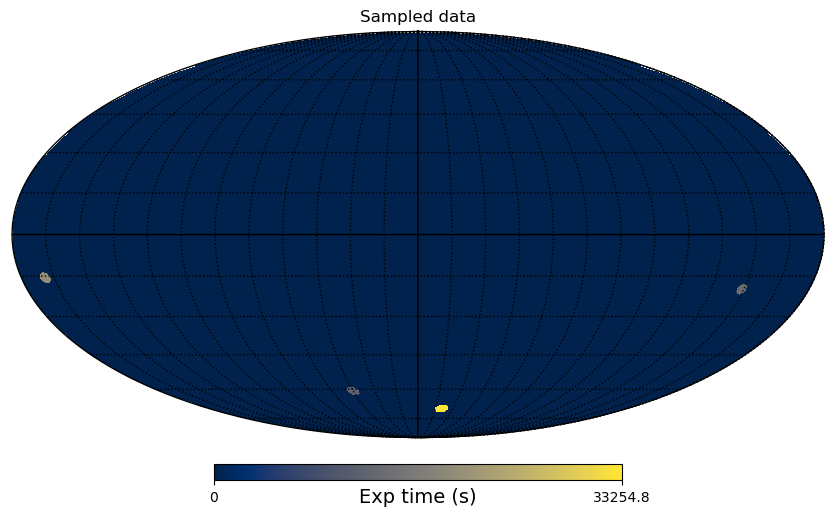

In [18]:
#Read data:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr = readFitsDir("../raw_data/MRS_goodTest",skymap=True,defr=False,sysError=0.25)

## Samples

In [12]:
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data
folderName = 'jw01751-o020_t008_miri'
#fitsFile = "../raw_data/MRS_all_data/"+folderName+"/x1d_ch1.fits"
fitsFile = "../raw_data/1spec/"+folderName+"/"+folderName+"_ch4-shortmediumlong_x1d.fits"
sub = fits.open(fitsFile)
print(sub.info())
print('###############################################################################')
print(sub[1].header['SRCTYPE'])
print(sub[0].header['SRCTYAPT'])
print(sub[0].header['BKGDTARG'])
#print(sub[0].header['BKGSUB'])
print(sub[0].header['S_MRSMAT'])
#print(sub[0].header['S_BKDSUB'])
#print(sub[0].header['S_MSBSUB'])
print(sub[0].header['EFFEXPTM'])
print(sub[0].header['ASNPOOL'])
print('###############################################################################')
print(sub[0].header)
# # from stdatamodels.jwst.datamodels import ImageModel
# # model = ImageModel(fitsFile)
# # model.data
# import stdatamodels.asdf_in_fits as asdfInFits
# af = asdfInFits.open(fitsFile)
# print(af.tree['meta'])

Filename: ../raw_data/1spec/jw01751-o020_t008_miri/jw01751-o020_t008_miri_ch4-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     376   ()      
  1  EXTRACT1D     1 BinTableHDU     69   1834R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [42359B]   
None
###############################################################################
EXTENDED
EXTENDED
False
SKIPPED
19780.847999999998
jw01751_20240705t072749_pool.csv
###############################################################################
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  DATE    = '2024-07-05T10:36:46.226' /

In [13]:
folderName = 'jw01282-o124_t066_miri'
rf = readFits('../raw_data/MRS_156/'+folderName,
        defringe=False,
        sysErr=0.1)

# Stack spectra

In [14]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=False)

Estimated log-signal-to-noise ratio:
[18.49896507 25.83147098 31.3302631  35.2387864 ]
[ 0.3301809  -0.06924852]


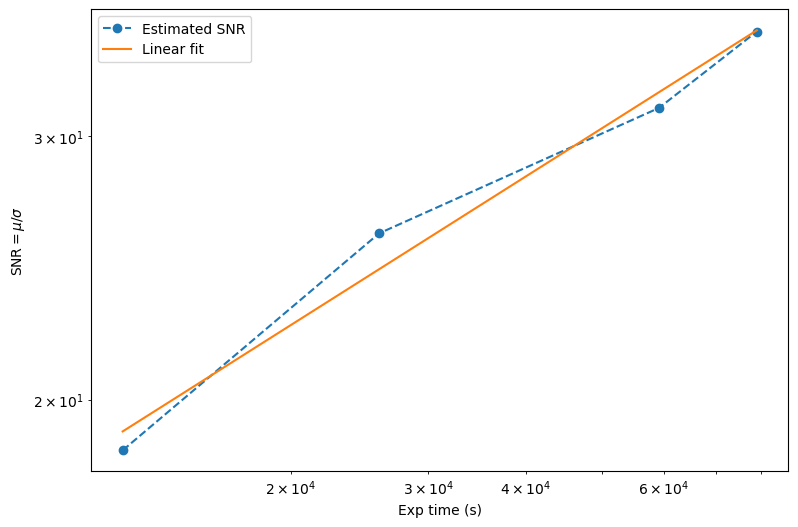

In [15]:
print('Estimated log-signal-to-noise ratio:')
print(SNR)
plt.figure(figsize=(9,6))
plt.plot(exptime,SNR,'--o',label='Estimated SNR')
plt.plot()
plt.ylabel('SNR$=\\mu/\\sigma$')
plt.xlabel('Exp time (s)')
plt.xscale('log')
plt.yscale('log')
#linear regression
p, lsq = linReg(np.log10(exptime),np.log10(SNR))
print(p)
plt.plot(exptime,10**p[1]*exptime**p[0],'-',label='Linear fit')
plt.legend()

This SNR plot is not accurate as for each exposure time, the artificial systematic error is not added suitably. One should expect that the systematic error required to add will decrease with exposure time as the systematic error in the underestimation of statistical error will be reduced.

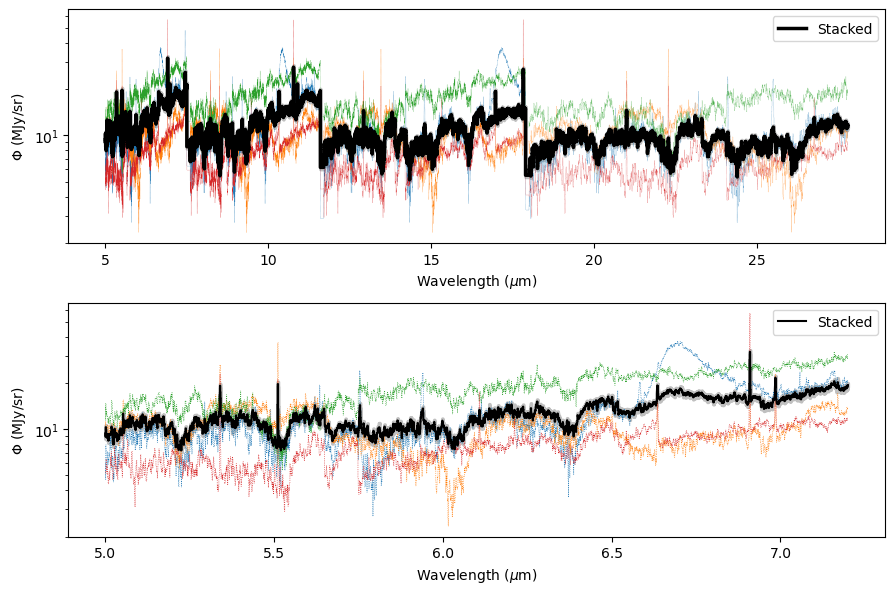

In [16]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5, M2=7.2, Ch1Arr=Ch1Arr, Ch2Arr=Ch2Arr, Ch3Arr=Ch3Arr, Ch4Arr=Ch4Arr, plotStyl='log') 

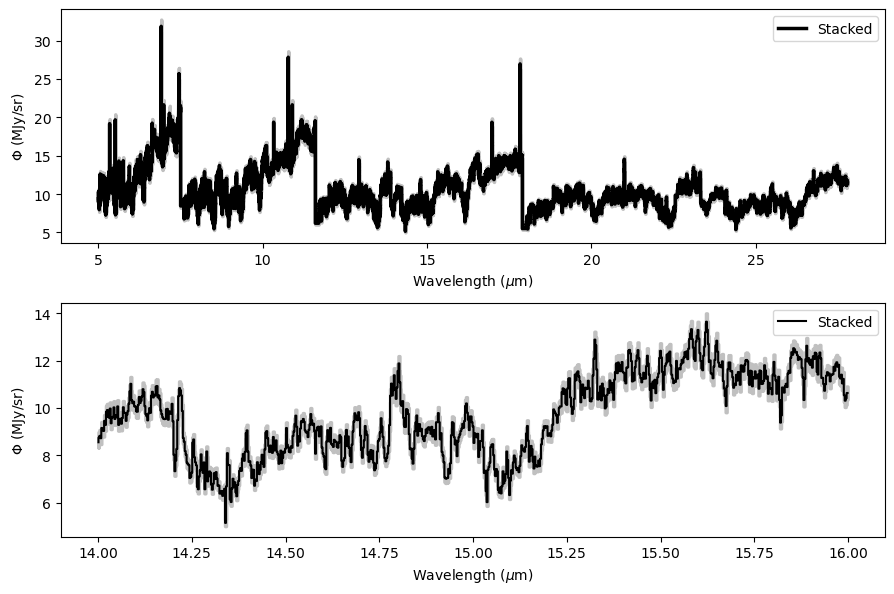

In [17]:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=14, M2=16, plotStyl='linear')

In [146]:
#Output array files:
np.savez('stkData.npz', ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)
np.savez('metaData.npz', expt=exptArr, l=longArr, b=latArr)

# Testing

In [ ]:
import scipy.constants as constants
print(constant

* Really small SNR + wrong powerf
* undefined error in ch4